# Lab 10: Sentiment Analysis for Beer Reviews (2/2)

<br>

[<img width=500 align="center" margin="20" src="wc_feel.jpg">](http://www.recommend.beer/analysis/)


In this lab we will continue working with beer reviews for sentiment analysis. We will build better classifiers by using document embeddings and methods like logistic regression and KNN classification.

Document embeddings are representations of documents as vectors, and are analogous to word embeddings. They can be constructed from word embeddings by composing them, or by building them in a similar manner to word embeddings.

Classifiers are models that take as input a set of features and output a discrete label (a class like 'positive', 'negative', 'neutral'). The input features we will use are the document embeddings of the review. Whereas we previously used rule-based methods based on small lists of words to construct the sentiment classifier, now we will use machine learning methods to approximate a relationship between reviews and their sentiment.

We will explore three types of models in this lab:
- Document embeddings by taking the mean of word embeddings
- Document embeddings by taking a weighted sum of word embeddings
- Document embeddings by using Doc2Vec, an algorithm that is similar in spirit to Word2Vec.

As always, load the usual modules.

In [1]:
from datascience import *
import numpy as np
import re
import gensim

from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Load and Split Dataset

As before, load the `csv` file that contains our beer reviews.

In [2]:
# load file and build table
filename = "ratings.csv"
data = Table.read_table(filename)
sample_size = data.num_rows
data.show(2)

beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_profileName,review_taste,review_text,review_time
5.4,63836,8481,John Harvards Simcoe IPA,India Pale Ale (IPA),4/5,6/10,13/20,3/5,hopdog,6/10,"On tap at the Springfield, PA location. Poured a deep an ...",1157587200
6.5,58511,3228,Barley Island Barfly IPA,India Pale Ale (IPA),3/5,5/10,8/20,2/5,jake65,4/10,"Bottle: Pours a murky caramel color with a modest, crea ...",1227744000


As before, transform the review scores from strings like `"4/5"` into integers like `4`.

In [3]:
# transform columns with scoring into ints
review_cols = ["review_appearance", "review_aroma", "review_overall", "review_palate", "review_taste"]

def transform_int(score):
    return int(re.match(r'([0-9]*)\/', score)[1])

for col in review_cols:
    review_score = data.apply(transform_int, col)
    data = data.drop(col)
    data = data.with_column(col, review_score)

data.show(2)

beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_profileName,review_text,review_time,review_appearance,review_aroma,review_overall,review_palate,review_taste
5.4,63836,8481,John Harvards Simcoe IPA,India Pale Ale (IPA),hopdog,"On tap at the Springfield, PA location. Poured a deep an ...",1157587200,4,6,13,3,6
6.5,58511,3228,Barley Island Barfly IPA,India Pale Ale (IPA),jake65,"Bottle: Pours a murky caramel color with a modest, crea ...",1227744000,3,5,8,2,4


Now, label the reviews into 3 classes: positive, neutral and negative. 

Previously, we took the the first third of reviews sorted by increasing overall review score as labelled negative, the next third neutral, and the last third positive. The problem with this is that a review given a score of, say 15, may be labelled as neutral and another review with that same score may be labelled as positive.

A better approach is to find the overall review score associated to the review at the 33rd and 66th percentile, and define our class thresholds according to that score.

In [4]:
# sort by increasing review overall score
data = data.sort("review_overall")

# label class
c2i = {"negative": 1,
       "neutral": 2,
       "positive": 3}

# find score associated with tertiles
thresh_neg = np.percentile(data.column("review_overall"), q=33)
thresh_neu = np.percentile(data.column("review_overall"), q=66)

print('negative threshold: %.0f\nneutral threshold: %.0f\n' % (thresh_neg, thresh_neu))

# label classes
def label_class(score, thresh_neg, thresh_neu):
    if score <= thresh_neg:
        return c2i["negative"]
    elif score <= thresh_neu:
        return c2i["neutral"]
    else:
        return c2i["positive"]
scores = data.column("review_overall")
labels = [label_class(score, thresh_neg, thresh_neu) for score in scores] 

# add to data
data = data.with_column("class", labels)
data.show(2)

negative threshold: 12
neutral threshold: 15



beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_profileName,review_text,review_time,review_appearance,review_aroma,review_overall,review_palate,review_taste,class
5,51707,156,Lakefront New Grist Sorghum Beer,Specialty Grain,roder60,Poured a very light offwhite offyellow color with almost ...,1193875200,1,2,1,1,2,1
5,44918,49,Molson Kick,Spice/Herb/Vegetable,Kinger,"UPDATED: JAN 2, 2006 Bottle. I cant believe I was into t ...",1135987200,1,1,1,1,1,1


Let's take a look at the distribution of the resulting classes.

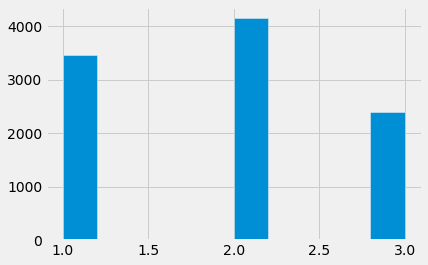

In [5]:
plt.hist(labels)
plt.show()

In the following sections, we again develop different models to score the sentiment of a beer review. As before, split the dataset into a training set (80%) and test set (20%). Recall that the training set will be used to develop the model, while the test set will be used to evaluate the model. This allows us to more reliably evaluate the model. 

In [6]:
# split to training and test set
from sklearn.model_selection import train_test_split
seed = 123

train, test = train_test_split(data.to_df(), test_size=0.20, random_state=seed)
train = Table.from_df(train)
test = Table.from_df(test)

x_train = train.column("review_text")
y_train = train.column("class")
scores_train = train.column("review_overall")

x_test = test.column("review_text")
y_test = test.column("class")
scores_test = test.column("review_overall")

## Load GloVe Word Embeddings

Let's load the 100-dimensional GloVe embeddings we worked with in labs 08 and 09. Recall that these are trained using word cooccurrence counts from about 6 billion words of text from Wikipedia pages.

In [7]:
import gensim
import gensim.downloader as gdl
from gensim.models import KeyedVectors

glove = gdl.load("glove-wiki-gigaword-100")

## Utility Functions

Let's define the functions we've been using for preprocessing of documents. Recall that we also lemmatize words (verbs) to derive their root form.

In [8]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def is_numeric(string):
    return any(char.isdigit() for char in string)

def has_poss_contr(string):
    return '\'s' in string

def empty_string(string):
    return not string

def remove_string(string):
    return is_numeric(string) or has_poss_contr(string) or empty_string(string)

def preprocess_data(docs):
    docs = [re.sub(r'[^\w\s]', '', doc) for doc in docs]
    docs_tok = [doc.lower().strip().split(' ') for doc in docs]
    docs_tok = [[tok for tok in doc if not remove_string(tok)] for doc in docs_tok]
    docs_tok = [[lemmatizer.lemmatize(tok, pos='v') for tok in doc] for doc in docs_tok]
    return docs_tok

We now define a couple more utility functions. The first filters a list of `tokens` and only keeps those that are in `vocab`. This helps us deal with tokens that may be out of GloVe's vocabulary by removing them. The second (from the previous lab) uses a model to predict the classes of reviews in `features`, and calculates the accuracy against `labels`.

In [9]:
def filter_not_in_vocab(tokens, vocab):
    return [token for token in tokens if token in vocab]

def evaluate(model, features, labels, split=None):
    pred_class = model.predict(features)
    acc = np.mean(np.equal(labels, pred_class))
    print("Classification accuracy (%s): %f" % (split, acc))
    return pred_class

## 1) Document Embeddings by Taking the Mean of Word Embeddings

One simple approach to obtaining document embeddings is to average out all the word embeddings for each token in the document.

$$
    a = \frac{1}{|D|}\sum_{w \in D} \phi(w)
$$

The result will be stored in a matrix, a data structure that stores an array of arrays.

$$
    \begin{pmatrix}
        a_1 & a_2 & \dots & a_d \\
        b_1 & b_2 & \dots & b_d \\
        \vdots & \vdots & \ddots & \vdots \\
        c_1 & c_2 & \dots & c_d \\
    \end{pmatrix}
$$

Each row in this matrix corresponds to a document embedding (a list of numbers `a = [a_1,a_2,...,a_d]`). Each embedding will, in our case, be of size $d=100$ since we average over 100-dimensional GloVe vectors. This will be the vector representation of a review. So, the matrix has $n$ rows and $d = 100$ columns, where $n$ is the number of documents.

In [10]:
# import nltk
# nltk.download('wordnet')

In [11]:
def get_doc_emb_avg(docs, emb_model):
    
    # vocab
    if emb_model == glove:
        vocab = glove.vocab
    elif emb_model == w2v:
        vocab = w2v.wv.vocab
    
    # preprocess data and filter tokens not in  vocab
    docs_tok = preprocess_data(docs)
    docs_tok = [filter_not_in_vocab(docs, vocab) for docs in docs_tok]
    
    # function to average vectors
    def average_vectors(tokens):
        vectors = []
        for token in tokens:
            vectors.append(emb_model[token])
        return np.mean(vectors, axis=0)
    
    # get a list of document vectors
    docs_emb = [average_vectors(tokens) for tokens in docs_tok]
    
    # stack document vectors into matrix
    docs_emb = np.vstack(docs_emb)
    
    return docs_emb

Below, we compute the document embeddings for `x_train` and `x_test` respectively. We also scale the embeddings so that they have mean 0 and variance 1; this is also called "standardization." It's a typical step in many machine learning methods so they will behave well, and we've also seen it for many statistical procedures in YData.


In [12]:
# get document embeddings 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

docs_emb_train = get_doc_emb_avg(x_train, glove)
docs_emb_test = get_doc_emb_avg(x_test, glove)

# scale the document embeddings 
x_train_feat = scaler.fit_transform(docs_emb_train)
x_test_feat = scaler.transform(docs_emb_test)

Next, we train our classifier. The first classifier we will consider is logistic regression. The simpler case is to predict among two classes (binary). 

$$
logit(\hat{p}) = \hat{\beta_0} + \hat{\beta_{1}}x_1 + ... + \hat{\beta_{100}}x_{100}
$$

In this case, we learn the coefficients $\beta$, just as we would for linear regression. Taking the weighted sum of components of the document embedding, weighting component $x_j$ by $\beta_j$, gives the log odds of the document belonging to a class.

In our case, we predict among 3 possible classes, so we have to extend binary logistic regression to multinomial logistic regression.

In [13]:
# train multinomial logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class='multinomial', 
                                solver='sag', max_iter=100)
model = clf.fit(x_train_feat, y_train)

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 0.570500
Classification accuracy (test): 0.555000


/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The logistic regression gives us 0.555 accuraccy over the test set. Not bad!

We also try a k-NN classifier.

<img width=350 src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/Knn_k1_z96jba.png">

The idea of the k-NN classifier is to find the nearest k neighbors to a document in the vector space. The majority label among these k neighbors becomes the label of that document. We'll start with 1 nearest neighbor.

In [14]:
# train KNN classifier
from sklearn.neighbors import KNeighborsClassifier  
clf = KNeighborsClassifier(n_neighbors=1)  
model = clf.fit(x_train_feat, y_train) 

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 0.999250
Classification accuracy (test): 0.405500


The k-NN classifier doesn't perform as well as the logistic regression model. Can you suggest any reasons for this?

## Your turn! (1/2)

### Evaluating different k

Currently, we set $k=1$ so we effectively have a nearest neighbor classifier. How would performance change as we vary $k$?

Plot the training accuracy and test acccuracy of a k-NN classifier againt $k$. You want two lines in your plot.  You can use the following outline to get started.

Classification accuracy (train): 0.999250
Classification accuracy (test): 0.405500
Classification accuracy (train): 0.711500
Classification accuracy (test): 0.433000
Classification accuracy (train): 0.649500
Classification accuracy (test): 0.455000
Classification accuracy (train): 0.614375
Classification accuracy (test): 0.445000
Classification accuracy (train): 0.598375
Classification accuracy (test): 0.447500
Classification accuracy (train): 0.580125
Classification accuracy (test): 0.448000
Classification accuracy (train): 0.571125
Classification accuracy (test): 0.451500
Classification accuracy (train): 0.557250
Classification accuracy (test): 0.464000
Classification accuracy (train): 0.548750
Classification accuracy (test): 0.465500
Classification accuracy (train): 0.543625
Classification accuracy (test): 0.453000
Classification accuracy (train): 0.543000
Classification accuracy (test): 0.458500
Classification accuracy (train): 0.536375
Classification accuracy (test): 0.456500
Clas

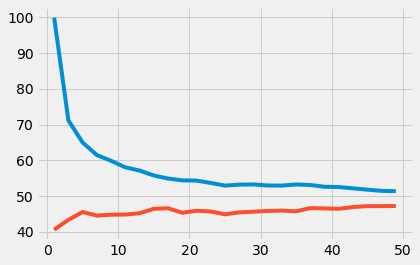

In [15]:
# define arrays for storing accuracies
accuracy_train = []
accuracy_test = []
# add to data
data = data.with_column("class", labels)
# define how we vary neighbours; don't change this!
neighbors = np.arange(1, 50, 2)
for k in neighbors:
    
    # train a KNN classifier with param k
    clf = KNeighborsClassifier(n_neighbors=k)  
    model = clf.fit(x_train_feat, y_train)

    # Note that this gives you the accuracy:
    # 100*sum(y_train==preds_train)/len(preds_train)

    # evaluate model on training set
    preds_train = evaluate(model, x_train_feat, y_train, split="train")
    accuracy_train.append(100*sum(y_train==preds_train)/len(preds_train))
    
    # evaluate model on test set
    preds_test = evaluate(model, x_test_feat, y_test, split="test") 
    accuracy_test.append(100*sum(y_test==preds_test)/len(preds_test))
    

# plot both relationships on a graph
# x axis: neighbours
# y axis: training accuracy, test accuracy

plt.plot(neighbors,accuracy_train)
plt.plot(neighbors,accuracy_test)
plt.show()

The performance can be seen to decrease over the training data and increase over the test data. It starts at nearly 100% for training, because it is overfit, which is also why is so low over the test data. Both the training and test accuracies can be seen to approach about 50%. Since the training and test accuracies are around the same, the model will generalize better and have a better overall performance even though the training accuracy is lower.

## 2) Document Embeddings using Weighted Sum of  Word Vectors

Another way to obtain document embeddings is to take a *weighted* sum of word embeddings. Intuitively, some words will be more important the others&mdash;this is why we selected lexicons of positive and negative words in the last lab. But how  should we weight the word embeddings? 

We can use tf-idf as weights. tf stands for *term frequency*, and idf stands for *inverse document frequency*. This is a statistical measure of how important a word is to a particular document among a large corpus of documents. 

Intuitively, the tf term reflects the idea that the importance of a word increases if it appears in a document more times. 

$$
    \text{tf}_D(w) = \frac{\text{# appearances of w in document D}}{\text{# words in D}}
$$

The idf term reflects the idea that the importance of a word decreases if it appears across many documents; e.g., `the` will appear in almost all documents, and so it's not informative.

$$
    \text{idf}(w) = \log\left(\frac{\text{# documents}}{\text{# documents that contain w}}\right)
$$

The tf-idf weight of a term is then just the product of tf and idf:

$$
    \text{tf-idf}_D(w) = tf(w) \times idf(w)
$$

We use this tf-idf weight for word w to form a weighted sum of the GloVe embedding vectors to obtain a document embedding:

$$
    a = \sum_{w \in D} \text{tf-idf}_D(w) \times \phi(w)
$$

As before, we store document embeddings in a matrix.

In [16]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
    
def get_doc_emb_tfidf(docs, emb_model):
    
    # vocab
    if emb_model == glove:
        vocab = glove.vocab
    elif emb_model == w2v:
        vocab = w2v.wv.vocab
    
    # build dictionary (vocabulary) over training set
    docs_tok = preprocess_data(docs)
    docs_tok = [filter_not_in_vocab(docs, vocab) for docs in docs_tok]
    docs_dict = Dictionary(docs_tok)
    docs_dict.filter_extremes(no_below=35, no_above=0.08)
    docs_dict.compactify()

    # build tfidf matrix for tokens in dictionary
    docs_corpus = [docs_dict.doc2bow(doc) for doc in docs_tok]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

    # build matrix of glove vectors for each token
    tfidf_emb_vecs = np.vstack([emb_model[docs_dict[i]] for i in range(len(docs_dict))])
    
    # build document vectors, weighted by tfidf
    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
    return docs_emb

We scale the embeddings as before.

In [17]:
# get document embeddings 
from sklearn.preprocessing import StandardScaler
x_full = np.concatenate((x_train, x_test), axis=0)
docs_emb = get_doc_emb_tfidf(x_full, glove)

# we have to split into the embeddings for train docs and for test docs
docs_emb_train = docs_emb[:train.num_rows,]
docs_emb_test = docs_emb[train.num_rows:,] 

# scale embeddings
x_train_feat = scaler.fit_transform(docs_emb_train)
x_test_feat = scaler.transform(docs_emb_test)

Finally, we train new classifiers using logistic regression and k-NN classification.

In [18]:
# train multinomial logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class='multinomial', 
                         solver='sag', max_iter=100)
model = clf.fit(x_train_feat, y_train)

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 0.553000
Classification accuracy (test): 0.523500


What can we say about the accuracy compared with the previous logistic regression model? Can you think of any possible explanation for this? How might we try to improve the model?


Next we'll train the k-NN classifier.

In [19]:
# train KNN classifier
from sklearn.neighbors import KNeighborsClassifier  
clf = KNeighborsClassifier(n_neighbors=7)  
model = clf.fit(x_train_feat, y_train) 

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 0.609375
Classification accuracy (test): 0.459500


## Document Embeddings using Doc2Vec

The last method we will consider for document embeddings is called Doc2Vec. The details are not necessary here, but the algorithm is similar to Word2Vec. This takes a while to run, so we can simply load from a previously saved model.

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
x_full = np.concatenate((x_train, x_test), axis=0)

docs = preprocess_data(x_full)
tagged_docs = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(docs)]

In [21]:
# # train d2v model
# max_epochs = 100
# vec_size = 100
# alpha = 0.025

# d2v = Doc2Vec(size=vec_size,
#               alpha=alpha, 
#               min_alpha=0.00025,
#               min_count=1,
#               dm=1)
  
# d2v.build_vocab(tagged_docs)

# for epoch in range(max_epochs):
#     if epoch % 10 == 0:
#         print('iteration {0}'.format(epoch))
#     d2v.train(tagged_docs,
#                 total_examples=d2v.corpus_count,
#                 epochs=model.iter)
#     # decrease the learning rate
#     d2v.alpha -= 0.0002
#     # fix the learning rate, no decay
#     d2v.min_alpha = d2v.alpha

# d2v.save("100-d2v.model")

In [22]:
d2v = Doc2Vec.load("100-d2v.model")

As before, scale the embeddings.

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# build the matrix
docs_emb = np.vstack([d2v.docvecs[str(i)] for i in range(data.num_rows)])

# we have to split into the embeddings for train docs and for test docs
docs_emb_train = docs_emb[:train.num_rows,]
docs_emb_test = docs_emb[train.num_rows:,] 

# scale embeddings
x_train_feat = scaler.fit_transform(docs_emb_train)
x_test_feat = scaler.transform(docs_emb_test)

Train a logistic regression model...

In [24]:
# train multinomial logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class='multinomial', 
                         solver='sag', max_iter=100)
model = clf.fit(x_train_feat, y_train)

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 0.615875
Classification accuracy (test): 0.590500


The model performs well, with 0.591 accuracy on the test set. 

Train a KNN classifier...

In [25]:
# train KNN classifier
from sklearn.neighbors import KNeighborsClassifier  
clf = KNeighborsClassifier(n_neighbors=1)  
model = clf.fit(x_train_feat, y_train) 

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

# from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test, preds_test))  
# print(classification_report(y_test, preds_test))  

Classification accuracy (train): 1.000000
Classification accuracy (test): 0.381000


This seems to do poorly once again.

## Your turn! (2/2)

### Word2Vec embeddings

Currently, we use GloVe word embeddings to build document embeddings. How might the performance change if we use Word2Vec embeddings constructed from the training set instead?

First, train word embeddings on `x_train` by filling in the following chunk.

In [26]:
from gensim.models import word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)

docs = preprocess_data(x_train)
w2v = word2vec.Word2Vec(docs, size=100, window=10, iter=10, min_count=10)


In [27]:
# from gensim.models import word2vec
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
#                     level=logging.INFO)
# max_epochs = 100
# vec_size = 100
# alpha = 0.025
# docs = preprocess_data(x_train)
# tagged_docs = [' '.join(i) for i in docs]#[TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(docs)]
# # print(tagged_docs[:10])
# w2v = word2vec.Word2Vec(docs, size=100, window=10, iter=10, min_count=10)
# #build_vocab(sentences=None, corpus_file=None, update=False, progress_per=10000, keep_raw_vocab=False, trim_rule=None, **kwargs
# w2v.build_vocab(sentences = tagged_docs, update = True)

# for epoch in range(max_epochs):
#     if epoch % 10 == 0:
#         print('iteration {0}'.format(epoch))
#     w2v.train(tagged_docs,
#                 total_examples=w2v.corpus_count,
#                 epochs=10)
#     # decrease the learning rate
#     w2v.alpha -= 0.0002
#     # fix the learning rate, no decay
#     w2v.min_alpha = w2v.alpha


In [28]:
# w2v.save("100-w2v.model")

Second, get document embeddings via the first method (mean of word embeddings). Then, scale the document embeddings. Your code for the following chunks should look like what has been given above.

In [29]:
# get document embeddings
docs_emb_train = get_doc_emb_avg(x_train, w2v)
docs_emb_test = get_doc_emb_avg(x_test, w2v)

# scale the document embeddings 
x_train_feat = scaler.fit_transform(docs_emb_train)
x_test_feat = scaler.transform(docs_emb_test)

Third, train a logistic regression model, and evaluate its performance.

In [30]:
# train and evaluate logistic regression model
clf = LogisticRegression(random_state=0, multi_class='multinomial', 
                         solver='sag', max_iter=100)
model = clf.fit(x_train_feat, y_train)

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")


Classification accuracy (train): 0.594250
Classification accuracy (test): 0.571000


/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fourth, train a KNN classifier model, and evaluate its performance.

In [31]:
# train and evaluate KNN classifier model
clf = KNeighborsClassifier(n_neighbors=1)  
model = clf.fit(x_train_feat, y_train) 

# evaluate model on train set
preds_train = evaluate(model, x_train_feat, y_train, split="train")

# evaluate model on test set
preds_test = evaluate(model, x_test_feat, y_test, split="test")

Classification accuracy (train): 0.999125
Classification accuracy (test): 0.461000


Classification accuracy (train): 0.999125
Classification accuracy (test): 0.461000
Classification accuracy (train): 0.721375
Classification accuracy (test): 0.490000
Classification accuracy (train): 0.666625
Classification accuracy (test): 0.516000
Classification accuracy (train): 0.651750
Classification accuracy (test): 0.524500
Classification accuracy (train): 0.635625
Classification accuracy (test): 0.531500
Classification accuracy (train): 0.623125
Classification accuracy (test): 0.535000
Classification accuracy (train): 0.618750
Classification accuracy (test): 0.525000
Classification accuracy (train): 0.610250
Classification accuracy (test): 0.532000
Classification accuracy (train): 0.607625
Classification accuracy (test): 0.540500
Classification accuracy (train): 0.600125
Classification accuracy (test): 0.549000
Classification accuracy (train): 0.596625
Classification accuracy (test): 0.548500
Classification accuracy (train): 0.598875
Classification accuracy (test): 0.545500
Clas

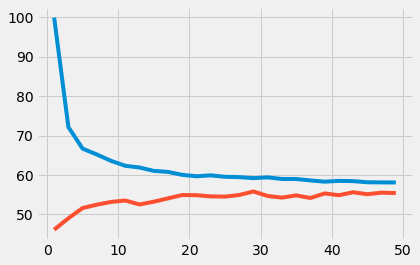

In [32]:
# define arrays for storing accuracies
accuracy_train = []
accuracy_test = []
# add to data
data = data.with_column("class", labels)
# define how we vary neighbours; don't change this!
neighbors = np.arange(1, 50, 2)
for k in neighbors:
    
    # train a KNN classifier with param k
    clf = KNeighborsClassifier(n_neighbors=k)  
    model = clf.fit(x_train_feat, y_train)

    # Note that this gives you the accuracy:
    # 100*sum(y_train==preds_train)/len(preds_train)

    # evaluate model on training set
    preds_train = evaluate(model, x_train_feat, y_train, split="train")
    accuracy_train.append(100*sum(y_train==preds_train)/len(preds_train))
    
    # evaluate model on test set
    preds_test = evaluate(model, x_test_feat, y_test, split="test") 
    accuracy_test.append(100*sum(y_test==preds_test)/len(preds_test))
    

# plot both relationships on a graph
# x axis: neighbours
# y axis: training accuracy, test accuracy

plt.plot(neighbors,accuracy_train)
plt.plot(neighbors,accuracy_test)
plt.show()

Discuss the performance of the models. How do they compare with the GloVe embeddings?

The models were very similar. Logistic regression was slightly better for w2v than GloVe, but worse than doc2vec. The kNN had results very similar to GloVe for the one iteration, so I decided to train similar to how it was done in part 1. Over a period of time, w2v outperformed the GloVe embeddings. With GloVe, the accuracies seemed to hover around 50%. For w2v, they seem to hover around 56%.